In [1]:
install_packages = false

if install_packages
    Pkg.add("PyPlot")
    Pkg.add("TestImages")
    Pkg.add("ImageFeatures")
    Pkg.add("Images")
    Pkg.add("ImageView")
    Pkg.update()
    Pkg.build("Cairo")
end

In [4]:
using TestImages
using ImageFeatures
using Images
using ImageView
using LIBSVM

In [3]:
path_positive_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians128x64/"
path_negative_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians_neg/"

pos_example_names = readdir(path_positive_examples)
neg_example_names = readdir(path_negative_examples)
pos_images = []
neg_images = []

for n in pos_example_names
    push!(pos_images, load( path_positive_examples * n))
end

for n in neg_example_names
    push!(neg_images, load( path_negative_examples * n))
end

### About hog
- https://github.com/JuliaImages/ImageFeatures.jl/blob/master/docs/src/tutorials/object_detection.md

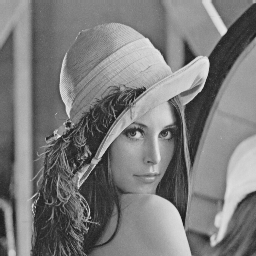

In [4]:
img = testimage("lena_gray")

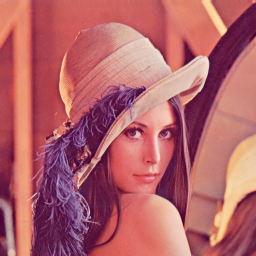

In [5]:
img = testimage("lena")

In [6]:
typeof(img)

Array{ColorTypes.RGB{FixedPointNumbers.Normed{UInt8,8}},2}

In [7]:
img_as_array = convert(Array{Float32},img);

LoadError: [91mMethodError: Cannot `convert` an object of type ColorTypes.RGB{FixedPointNumbers.Normed{UInt8,8}} to an object of type Float32
This may have arisen from a call to the constructor Float32(...),
since type constructors fall back to convert methods.[39m

In [8]:
minimum(img_as_array), maximum(img_as_array)

LoadError: [91mUndefVarError: img_as_array not defined[39m

## Descriptors

In [9]:
img = testimage("lena_gray")
gx = imfilter(img, centered([-1 0 1]))
gy = imfilter(img, centered([-1 0 1]'));

In [10]:
size(img), size(gx)

((256, 256), (256, 256))

In [11]:
img = testimage("lena_gray")
gx = imfilter(img, centered([-1 0 1]))
gy = imfilter(img, centered([-1 0 1]'));

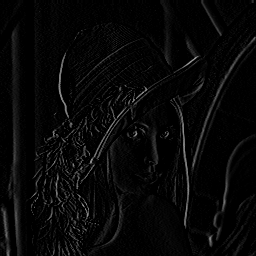

In [12]:
gx

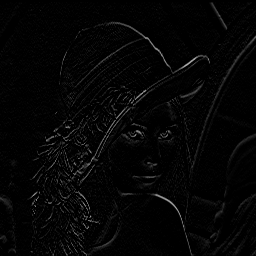

In [13]:
gy

In [14]:
summary(gx)

"256×256 Array{Gray{Float32},2}"

### We can plot using PyPlot if we convert the images to standard arrays

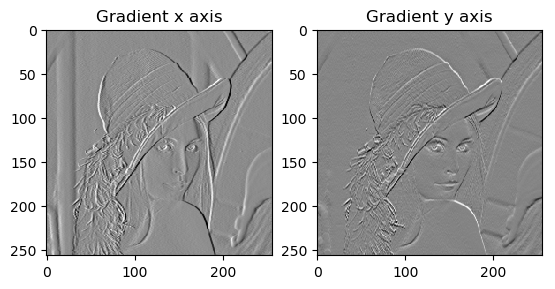

In [15]:
using PyPlot

figure, axis = PyPlot.subplots(1,2);

axis[1][:imshow](convert(Array{Float32},gx), cmap="gray")
axis[1][:set_title]("Gradient x axis" )

axis[2][:imshow](convert(Array{Float32},gy), cmap="gray")
axis[2][:set_title]("Gradient y axis")

PyPlot.show()

## HOG descriptor imported not working

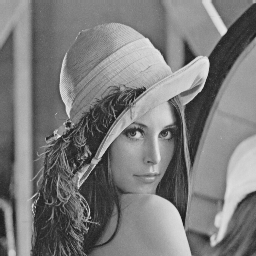

In [16]:
img = testimage("lena_gray")

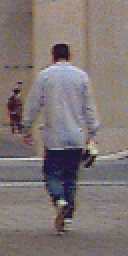

In [17]:
img = load("/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians128x64/per00001.ppm")

In [32]:
h = HOG(orientations=8,
        cell_size=8,
        block_size = 2,
        block_stride = 2,
        norm_method="L2-norm")

ImageFeatures.HOG(8, 8, 2, 2, "L2-norm")

In [33]:
create_descriptor(img, HOG()) 

LoadError: [91mBoundsError: attempt to access 9×16×8 Array{Float64,3} at index [10, 1, 1][39m

In [31]:
typeof(img)

Array{ColorTypes.RGB{FixedPointNumbers.Normed{UInt8,8}},2}

## Hog descriptor copied works 

#### Code copied from ImageFeatures works!

- Data: https://github.com/mbeyeler/opencv-machine-learning/tree/78f5f6ecfbbae3f61b378060d60641420331115c/notebooks/data/chapter6

In [38]:
import  ImageFeatures.create_descriptor

In [39]:
mutable struct HOG
    orientations::Int 
    cell_size::Int
    block_size::Int
    block_stride::Int 
    norm_method::String
end

function HOG(; orientations::Int = 9, cell_size::Int = 8, block_size::Int = 2, block_stride::Int = 1, norm_method::String = "L2-norm")
    HOG(orientations, cell_size, block_size, block_stride, norm_method)
end

function create_descriptor(img::AbstractArray{CT, 2}, params::HOG) where CT<:Images.NumberLike
    #compute gradient
    gx = imfilter(img, centered([-1 0 1]))
    gy = imfilter(img, centered([-1 0 1]'))
    mag = hypot.(gx, gy)
    phase = orientation.(gx, gy)

    create_hog_descriptor(mag, phase, params)
end

function create_descriptor(img::AbstractArray{CT, 2}, params::HOG) where CT<:Images.Color{T, N} where T where N
    #for color images, compute seperate gradient for each color channel and take one with largest norm as pixel's gradient vector
    rows, cols = size(img)
    gx = channelview(imfilter(img, centered([-1 0 1])))
    gy = channelview(imfilter(img, centered([-1 0 1]')))
    mag = hypot.(gx, gy)
    phase = orientation.(gx, gy)

    max_mag = zeros(rows, cols)
    max_phase = zeros(rows, cols)

    for j in indices(mag, 3)
        for i in indices(mag, 2)
            ind = indmax(mag[:, i, j])
            max_mag[i, j] = mag[ind, i, j]
            max_phase[i, j] = phase[ind, i, j]
        end
    end

    create_hog_descriptor(max_mag, max_phase, params)
end

function create_hog_descriptor(mag::AbstractArray{T, 2},
                               phase::AbstractArray{T, 2}, 
                               params::HOG) where T<:Images.NumberLike
    orientations = params.orientations
    cell_size = params.cell_size
    block_size = params.block_size
    block_stride = params.block_stride

    rows, cols = size(mag)
    if rows%cell_size!=0 || cols%cell_size!=0
        error("Height and Width of the image must be a multiple of cell_size.")
    end

    cell_rows::Int = rows/cell_size
    cell_cols::Int = cols/cell_size
    if (cell_rows-block_size)%block_stride!=0 || (cell_cols-block_size)%block_stride!=0
        error("Block size and block stride don't match.")
    end

    phase = abs.(phase*180/pi)
    #orientation binning for each cell
    hist = zeros(Float64, (orientations, cell_rows, cell_cols))
    R = CartesianRange(indices(mag))
    for i in R
        trilinear_interpolate!(hist, mag[i], phase[i], orientations, i, cell_size, cell_rows, cell_cols, rows, cols)
    end

    function normalize(v, method)
        if method == "L2-norm"
            return v./sqrt(sum(abs2, v) + 1e-5)
        elseif method == "L2-hys"
            v = v./(sum(abs2, v) + 1e-5)
            v = min.(v, 0.2)
            return v./(sum(abs2, v) + 1e-5)
        elseif method == "L1-norm"
            return v./(sum(abs, v) + 1e-5)
        elseif method == "L1-sqrt"
            return sqrt.(v./(sum(abs, v) + 1e-5))
        end
    end

    #contrast normalization for each block
    descriptor_size::Int = ((cell_rows-block_size)/block_stride + 1) * ((cell_cols-block_size)/block_stride + 1) * (block_size*block_size) * orientations
    descriptor = Vector{Float64}(descriptor_size)
    block_vector_size = block_size * block_size * orientations
    k = 1
    for j in 1:block_stride:cell_cols-block_size+1
        for i in 1:block_stride:cell_rows-block_size+1
            descriptor[block_vector_size*(k-1)+1 : block_vector_size*k] = normalize(hist[:, i:i+block_size-1, j:j+block_size-1][:], params.norm_method)
            k += 1
        end
    end
    return descriptor
end

function trilinear_interpolate!(hist, w, θ, orientations, i, cell_size, cell_rows, cell_cols, rows, cols)
    bin_θ1 = min(floor(Int, θ*orientations/180) + 1, orientations)
    bin_θ2 = bin_θ1%orientations + 1
    b_θ = 180/orientations

    if bin_θ1 != orientations
        θ1 = (bin_θ1-1)*180/orientations
        θ2 = (bin_θ2-1)*180/orientations
    else
        θ1 = (bin_θ1-1)*180/orientations
        θ2 = 180;
    end

    if (i[1]<=cell_size/2 || i[1]>=rows-cell_size/2) && (i[2]<=cell_size/2 || i[2]>=cols-cell_size/2)
        #linear interpolation for corner points
        bin_x = i[1] < cell_size/2 ? 1 : cell_rows
        bin_y = i[2] < cell_size/2 ? 1 : cell_cols

        hist[bin_θ1, bin_x, bin_y] += w*(1-(θ-θ1)/b_θ)
        hist[bin_θ2, bin_x, bin_y] += w*(1-(θ2-θ)/b_θ)

    elseif i[1]<=cell_size/2 || i[1]>=rows-cell_size/2
        #bilinear interpolation for (top/bottom) edge points
        bin_x = i[1] < cell_size/2 ? 1 : cell_rows
        bin_y1 = floor(Int, (i[2]+cell_size/2)/cell_size)
        bin_y2 = bin_y1 + 1

        y1 = (bin_y1-1)*cell_size+cell_size/2
        y2 = (bin_y2-1)*cell_size+cell_size/2
        b_y = cell_size

        hist[bin_θ1, bin_x, bin_y1] += w*(1-(θ-θ1)/b_θ)*(1-(i[2]-y1)/b_y)
        hist[bin_θ1, bin_x, bin_y2] += w*(1-(θ-θ1)/b_θ)*(1-(y2-i[2])/b_y)
        hist[bin_θ2, bin_x, bin_y1] += w*(1-(θ2-θ)/b_θ)*(1-(i[2]-y1)/b_y)
        hist[bin_θ2, bin_x, bin_y2] += w*(1-(θ2-θ)/b_θ)*(1-(y2-i[2])/b_y)

    elseif  i[2]<=cell_size/2 || i[2]>=cols-cell_size/2
        #bilinear interpolation for (left/right) edge points
        bin_x1 = floor(Int, (i[1]+cell_size/2)/cell_size)
        bin_x2 = bin_x1 + 1
        bin_y = i[2] < cell_size/2 ? 1 : cell_cols

        x1 = (bin_x1-1)*cell_size+cell_size/2
        x2 = (bin_x2-1)*cell_size+cell_size/2
        b_x = cell_size

        hist[bin_θ1, bin_x1, bin_y] += w*(1-(θ-θ1)/b_θ)*(1-(i[1]-x1)/b_x)
        hist[bin_θ1, bin_x2, bin_y] += w*(1-(θ-θ1)/b_θ)*(1-(x2-i[1])/b_x)
        hist[bin_θ2, bin_x1, bin_y] += w*(1-(θ2-θ)/b_θ)*(1-(i[1]-x1)/b_x)
        hist[bin_θ2, bin_x2, bin_y] += w*(1-(θ2-θ)/b_θ)*(1-(x2-i[1])/b_x)
    else
        #trilinear interpolation
        bin_x1 = floor(Int, (i[1]+cell_size/2)/cell_size)
        bin_x2 = bin_x1 + 1
        bin_y1 = floor(Int, (i[2]+cell_size/2)/cell_size)
        bin_y2 = bin_y1 + 1

        x1 = (bin_x1-1)*cell_size+cell_size/2
        x2 = (bin_x2-1)*cell_size+cell_size/2
        b_x = cell_size

        y1 = (bin_y1-1)*cell_size+cell_size/2
        y2 = (bin_y2-1)*cell_size+cell_size/2
        b_y = cell_size

        hist[bin_θ1, bin_x1, bin_y1] += w*(1-(θ-θ1)/b_θ)*(1-(i[1]-x1)/b_x)*(1-(i[2]-y1)/b_y)
        hist[bin_θ1, bin_x1, bin_y2] += w*(1-(θ-θ1)/b_θ)*(1-(i[1]-x1)/b_x)*(1-(y2-i[2])/b_y)
        hist[bin_θ1, bin_x2, bin_y1] += w*(1-(θ-θ1)/b_θ)*(1-(x2-i[1])/b_x)*(1-(i[2]-y1)/b_y)
        hist[bin_θ1, bin_x2, bin_y2] += w*(1-(θ-θ1)/b_θ)*(1-(x2-i[1])/b_x)*(1-(y2-i[2])/b_y)
        hist[bin_θ2, bin_x1, bin_y1] += w*(1-(θ2-θ)/b_θ)*(1-(i[1]-x1)/b_x)*(1-(i[2]-y1)/b_y)
        hist[bin_θ2, bin_x1, bin_y2] += w*(1-(θ2-θ)/b_θ)*(1-(i[1]-x1)/b_x)*(1-(y2-i[2])/b_y)
        hist[bin_θ2, bin_x2, bin_y1] += w*(1-(θ2-θ)/b_θ)*(1-(x2-i[1])/b_x)*(1-(i[2]-y1)/b_y)
        hist[bin_θ2, bin_x2, bin_y2] += w*(1-(θ2-θ)/b_θ)*(1-(x2-i[ 1])/b_x)*(1-(y2-i[2])/b_y)
    end
end

trilinear_interpolate! (generic function with 1 method)

In [40]:
path_positive_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians128x64/"
path_negative_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians_neg/"

pos_example_names = readdir(path_positive_examples)
neg_example_names = readdir(path_negative_examples)

n_pos = length(pos_example_names)
n_neg = length(neg_example_names)

n = n_pos + n_neg                       # number of training examples 
data = Array{Float32}(3780, n)          # Array to store HOG descriptor of each image. Each image in our training data has size 128x64 and so has a 3780 length 
labels = Vector{Int}(n);                 # Vector to store label (1=human, 0=not human) of each image.

for (i, file) in enumerate([pos_example_names ; neg_example_names])
    
    #filename = "$(i <= n_pos ? path_positive_examples : path_negative_examples)/$file"
    if i <= n_pos
        filename =  path_positive_examples * file
    else
        filename = path_negative_examples * file
    end
    
    img = load(filename)   
    if i > n_pos # negative samples are bigger, we take a patch of the same shape
        img = img[1:128, 1:64]
    end
    
    data[:, i] = create_descriptor(img, HOG())
    labels[i] = (i <= n_pos ? 1 : 0)
end

3780×974 Array{Float32,2}:
 0.222793   0.222793   0.27262    …  0.0684937  0.237724   4.31434f-13
 0.0518278  0.0518278  0.0511288     0.0401249  0.0463551  0.0        
 0.0497377  0.0497377  0.0904888     0.0545193  0.046466   0.0        
 0.0290854  0.0290854  0.134856      0.0727628  0.152483   0.0        
 0.146427   0.146427   0.131816      0.173331   0.178873   0.0        
 0.154912   0.154912   0.103797   …  0.189399   0.15852    0.0        
 0.0467725  0.0467725  0.0364054     0.14432    0.0929494  0.0        
 0.0717326  0.0717326  0.139924      0.0444055  0.102928   0.0        
 0.0888084  0.0888084  0.088192      0.0529897  0.19629    0.0        
 0.247078   0.247078   0.356254      0.0889559  0.117679   5.30996f-13
 0.0971141  0.0971141  0.0454943  …  0.0276107  0.0282956  0.0        
 0.134144   0.134144   0.105231      0.0104903  0.101369   0.0        
 0.120025   0.120025   0.148511      0.0264573  0.313265   0.0        
 ⋮                                ⋱               